# Accuracy

In this notebook we will take a first look at the impact on accuracy of a model when we use imbalanced data. We will compare the basic Uncertainty sampling of Active Learning against random sampling meaning no Active Learning.

In [1]:
## Imports ##

# numpy
import numpy as np

# matplotlib
import matplotlib as mlp
import matplotlib.pyplot as plt

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# skactiveml
from skactiveml.classifier import SklearnClassifier
from skactiveml.pool import UncertaintySampling
from skactiveml.pool import RandomSampling
from skactiveml.utils import MISSING_LABEL

# plot function
from plot_accuracy import plot_accuracy

# balanced accuracy
from balanced_accuracy import balanced_accuracy

# set warnings
import warnings
mlp.rcParams["figure.facecolor"] = "white"
warnings.filterwarnings("ignore")

[We already know](https://dsgissin.github.io/DiscriminativeActiveLearning/) that active learning algorithms can drastically reduce the amount of samples needed to be labeled in order to obtain good accuracy. We will now look at the accuracy when we use imbalanced data.

In [2]:
def get_accuracy(qs_type, weights=None, cycles=30, n_samples=400, **kwargs):
    data = []
    for rand in range(100):
        qs = qs_type(random_state=rand, **kwargs)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(yf))

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y) if type(qs) == RandomSampling else qs.query(Xf, y, clf)
            y[i] = yf[i]
            clf.fit(Xf,y)
            out.append(clf.score(Xt,yt))
        data.append(out)
    return np.mean(np.array(data), axis=0)

In [3]:
acc_nrml_random = get_accuracy(RandomSampling)
acc_imbalanced_random = get_accuracy(RandomSampling, weights=[0.8, 0.2])

In [4]:
acc_nrml_uncertainty = get_accuracy(UncertaintySampling, method='least_confident')
acc_imbalanced_uncertainty = get_accuracy(UncertaintySampling, weights=[0.8, 0.2], method='least_confident')

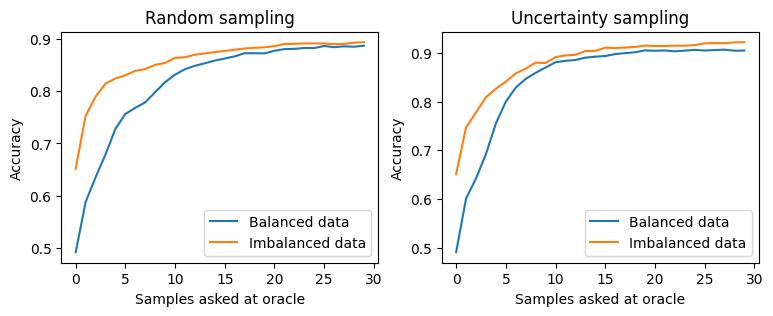

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

plot_accuracy('Random sampling', [[acc_nrml_random, "Balanced data"], 
                                  [acc_imbalanced_random, "Imbalanced data"]],
              axs[0])
plot_accuracy('Uncertainty sampling', [[acc_nrml_uncertainty, "Balanced data"], 
                                       [acc_imbalanced_uncertainty, "Imbalanced data"]],
              axs[1])

axs[0].set_ylabel('Accuracy')
axs[1].set_ylabel('Accuracy')

fig.show()

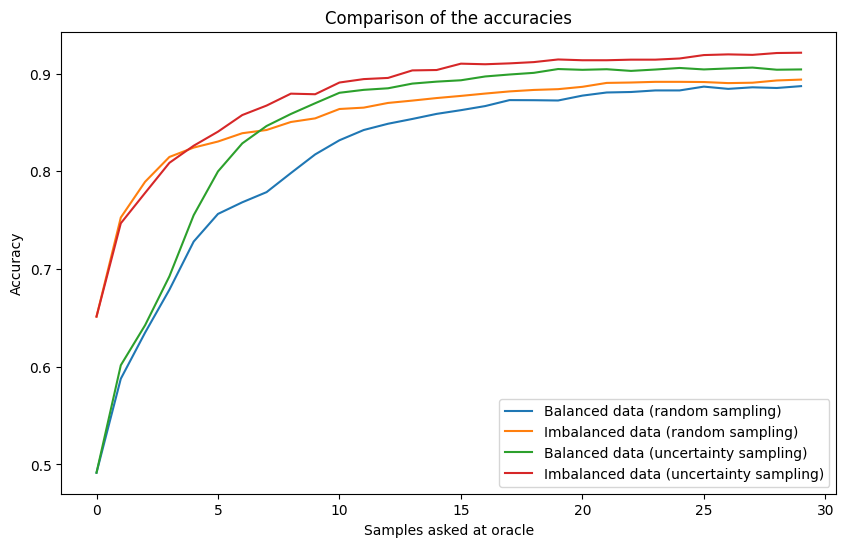

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Comparison of the accuracies', [[acc_nrml_random, "Balanced data (random sampling)"], 
                                               [acc_imbalanced_random, "Imbalanced data (random sampling)"],
                                               [acc_nrml_uncertainty, "Balanced data (uncertainty sampling)"], 
                                               [acc_imbalanced_uncertainty, "Imbalanced data (uncertainty sampling)"]],
              axs)

axs.set_ylabel('Accuracy')

fig.show()

When we compare the acquired results we get a shocking conclusion. Although Uncertainty sampling certainly performs better than the random sampling of no active learning, these results are maybe not accurate because the accuracy of imbalanced data is higher than those of the balanced data. We can conclude that our score function is incorrect so we implemented a balanced accuracy function ourselves.

In [7]:
def get_balanced_accuracy(qs_type, weights=None, cycles=30, n_samples=400, **kwargs):
    data = []
    for rand in range(100):
        qs = qs_type(random_state=rand, **kwargs)
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, weights=weights, random_state=rand)
        Xf, Xt, yf, yt = train_test_split(X, y, random_state=rand)
        y = np.full(shape=yf.shape, fill_value=MISSING_LABEL)
        out = []
        clf = SklearnClassifier(LogisticRegression(), classes=np.unique(yf))

        clf.fit(Xf, y)
        for _ in range(cycles):
            i = qs.query(Xf, y) if type(qs) == RandomSampling else qs.query(Xf, y, clf)
            y[i] = yf[i]
            clf.fit(Xf,y)
            out.append(balanced_accuracy(yt,clf.predict(Xt))) # new addition
        data.append(out)

    return np.mean(np.array(data), axis=0)

In [8]:
balanced_acc_nrml_random = get_balanced_accuracy(RandomSampling)
balanced_acc_imbalanced_random = get_balanced_accuracy(RandomSampling, weights=[0.8, 0.2])

In [9]:
balanced_acc_nrml_uncertainty = get_balanced_accuracy(UncertaintySampling, method='least_confident')
balanced_acc_imbalanced_uncertainty = get_balanced_accuracy(UncertaintySampling, weights=[0.8, 0.2], method='least_confident')

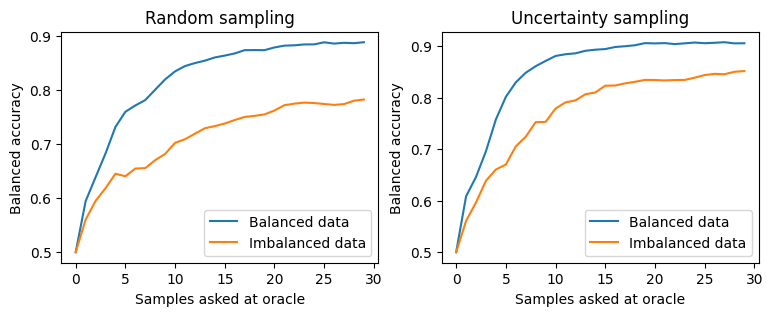

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))

plot_accuracy('Random sampling', [[balanced_acc_nrml_random, "Balanced data"], 
                                  [balanced_acc_imbalanced_random, "Imbalanced data"]],
              axs[0])
plot_accuracy('Uncertainty sampling', [[balanced_acc_nrml_uncertainty, "Balanced data"], 
                                       [balanced_acc_imbalanced_uncertainty, "Imbalanced data"]],
              axs[1])

fig.show()

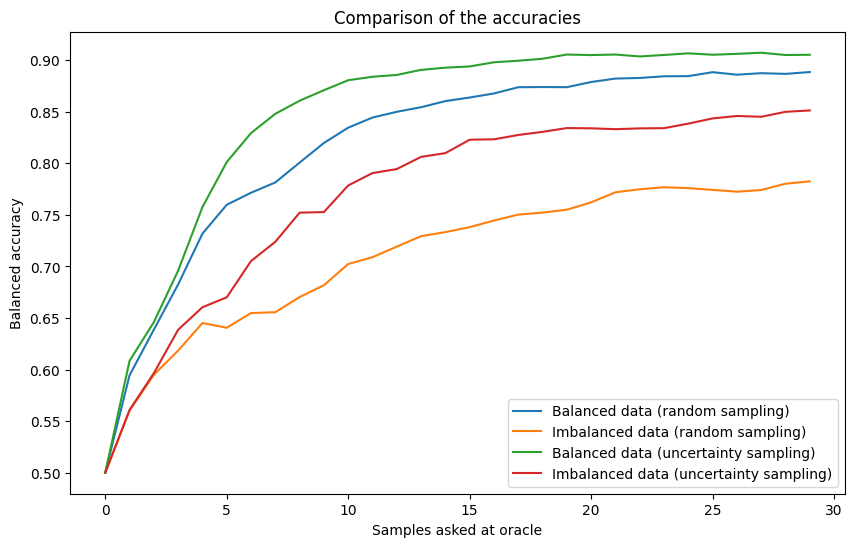

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

plot_accuracy('Comparison of the accuracies', [[balanced_acc_nrml_random, "Balanced data (random sampling)"], 
                                               [balanced_acc_imbalanced_random, "Imbalanced data (random sampling)"],
                                               [balanced_acc_nrml_uncertainty, "Balanced data (uncertainty sampling)"], 
                                               [balanced_acc_imbalanced_uncertainty, "Imbalanced data (uncertainty sampling)"]],
              axs)

fig.show()

Now we can clearly see better results. We can also see that Active learning shows a huge improvement in the accuracy on imbalanced data sets, but not enough to see that imbalanced data performs better than random sampling with balanced data.

From now on, we will use balanced accuracy for all our scores.